In [1]:
import os
import numpy as np
import cv2
import sys
import random

from vp_estimation_with_prior_gravity.features.line_detector import LineDetector
sys.path.append(os.path.join(os.path.dirname(os.path.abspath("")), "build/vp_estimation_with_prior_gravity"))
from vp_estimation_with_prior_gravity.solvers import run_hybrid_uncalibrated
from vp_estimation_with_prior_gravity.evaluation import project_vp_to_image, get_labels_from_vp
from vp_estimation_with_prior_gravity.visualization import plot_images, plot_vp, plot_lines

In [2]:
# Which solvers to us for our hybrid solver:
# 0 - 2lines 200g
# 1 - 2lines 110g
# 2 - 2lines 011g
# 3 - 4lines 211
# 4 - 4lines 220
SOLVER_FLAGS = [True, True, True, True, True]
th_pixels = 3  # RANSAC inlier threshold
ls_refinement = 2  # 3 uses the gravity in the LS refinement, 2 does not. Here we use a prior on the gravity, so use 2
nms = 1  # change to 3 to add a Ceres optimization after the non minimal solver (slower)
magsac_scoring = True

In [3]:
# Read the image
img_path = "../assets/images/P1080036.jpg"
img = cv2.imread(img_path, 0)

# We use a prior vertical gravity
if (SOLVER_FLAGS == [True, False, False, False, False]) or (SOLVER_FLAGS == [False, False, True, False, False]):
    vertical = np.array([random.random() / 1e12, 1, random.random() / 1e12])
    vertical /= np.linalg.norm(vertical)
else:
    vertical = np.array([0., 1, 0.])
    
# Intrinsics matrix obtained from the Yor Urban dataset
K = np.array([[674.91797516, 0., 306.55130528],
              [0., 674.91797516, 250.45424496],
              [0., 0., 1.]])

In [4]:
# Detect lines
line_type = 'lsd'  # 'lsd' or 'deeplsd'
line_detector = LineDetector(line_detector=line_type)
lines = line_detector.detect_lines(img)[:, :, [1, 0]]

In [5]:
# Run the VP estimation with our hybrid RANSAC
principle_point = np.array([img.shape[1] / 2.0, img.shape[0] / 2.0])
f, vp = run_hybrid_uncalibrated(
    lines - principle_point[None, None, :],
    vertical, th_pixels=th_pixels, ls_refinement=ls_refinement,
    nms=nms, magsac_scoring=magsac_scoring, sprt=True, solver_flags=SOLVER_FLAGS)
vp[:, 1] *= -1

# Get the line-VP assignment
vp_labels = get_labels_from_vp(lines[:, :, [1, 0]], project_vp_to_image(vp, K), threshold=th_pixels)[0]

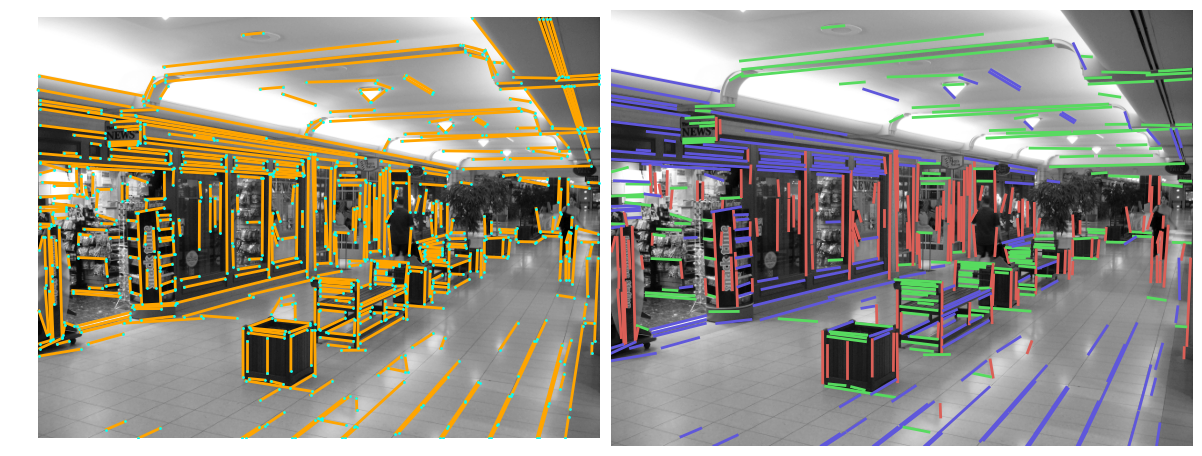

In [6]:
# Plot the results
plot_images([img, img])
plot_lines([lines, np.empty((0, 2, 2))])
plot_vp([np.empty((0, 2, 2)), lines], [[], vp_labels])